1. Загрузка необходимых пакетов и библиотек.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
import requests
from io import StringIO



In [2]:
# Загрузка данных
df = pd.read_csv("../datasets/V4_classification_lr3.csv") # Считываем данные из файла
# data_url = "https://drive.google.com/uc?export=download&id=16UQ0qrgQxDwT5URIrybAGiCX93cQQZW8" # Ссылка на скачивание CSV-файла,
# response = requests.get(data_url) # Получаем response по get-request\n",
# response.raise_for_status()       # Проверка на ошибки\n",
# data = StringIO(response.text)    # Формируем файл из содержимого респонса"
# df = pd.read_csv(data)

In [3]:
print("\n--- Первые 5 строк данных ---")
print(df.head())

print("\n--- Информация о данных ---")
df.info()

print("\n--- Описательная статистика для числовых признаков ---")
print(df.describe())

print("\n--- Распределение классов целевого признака 'Cover_Type' ---")
print(df['Cover_Type'].value_counts())

print("\n--- Проверка на пропущенные значения ---")
print(df.isnull().sum())

print("\n--- Проверка на дубликаты ---")
print(f"Количество дубликатов: {df.duplicated().sum()}")


--- Первые 5 строк данных ---
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0     2596.0    51.0    3.0                             258.0   
1     2590.0    56.0    2.0                             212.0   
2     2804.0   139.0    9.0                             268.0   
3     2785.0   155.0   18.0                             242.0   
4     2595.0    45.0    2.0                             153.0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                             0.0                            510.0   
1                            -6.0                            390.0   
2                            65.0                           3180.0   
3                           118.0                           3090.0   
4                            -1.0                            391.0   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0          221.0           232.0          148.0   
1          220.0           235.0          151.0   
2   


Количество числовых признаков: 54
Количество категориальных (бинарных) признаков: 44


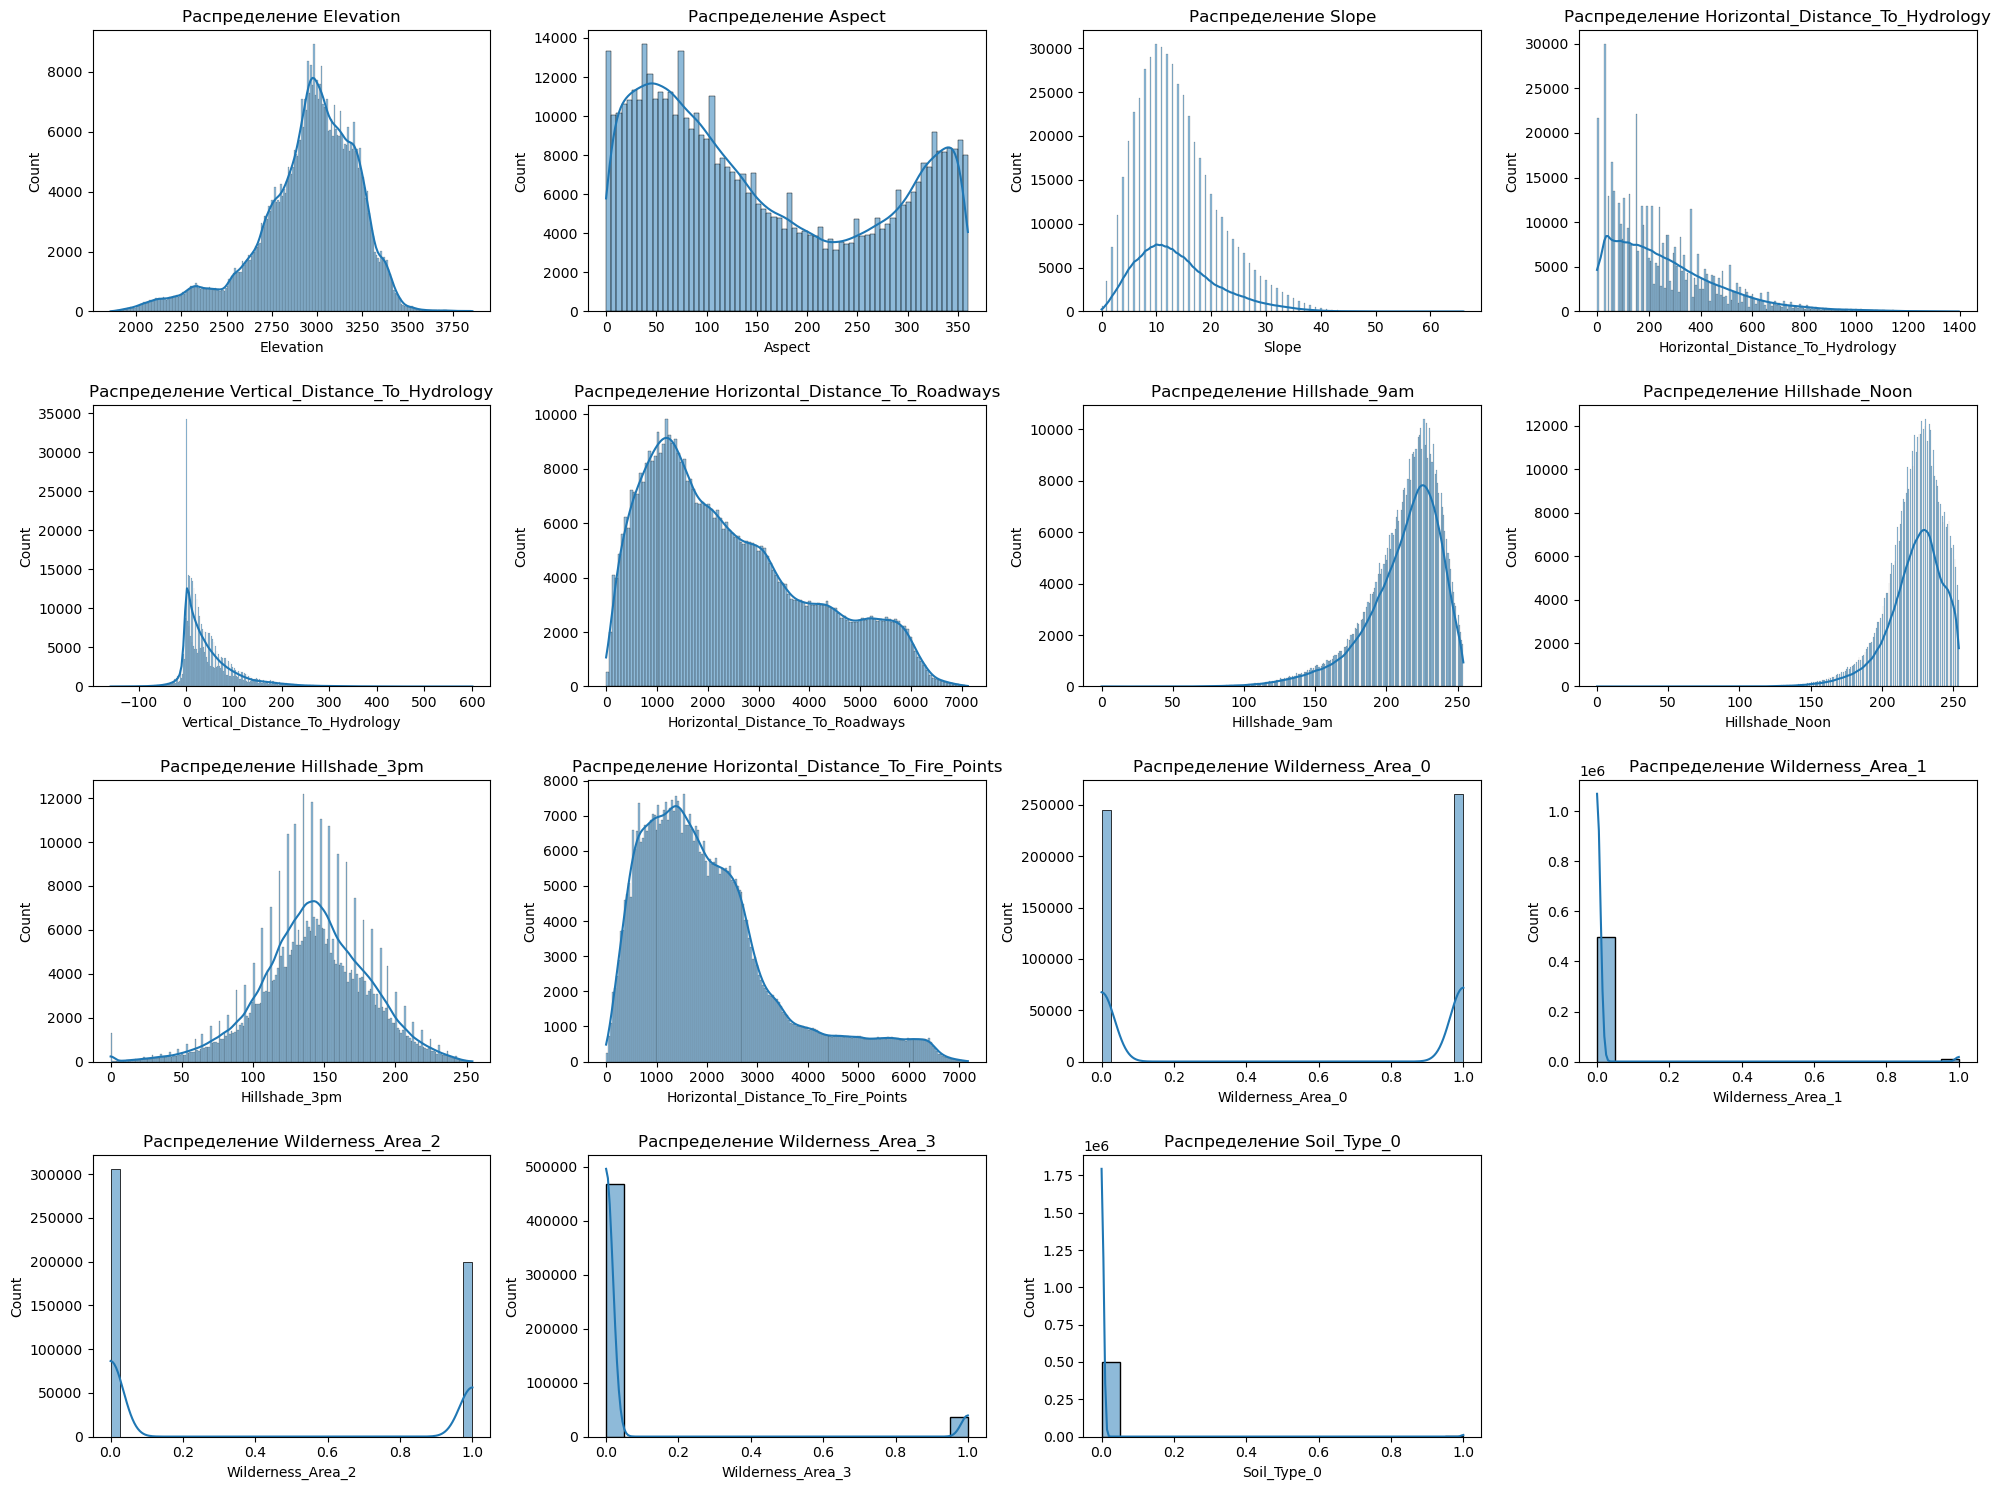

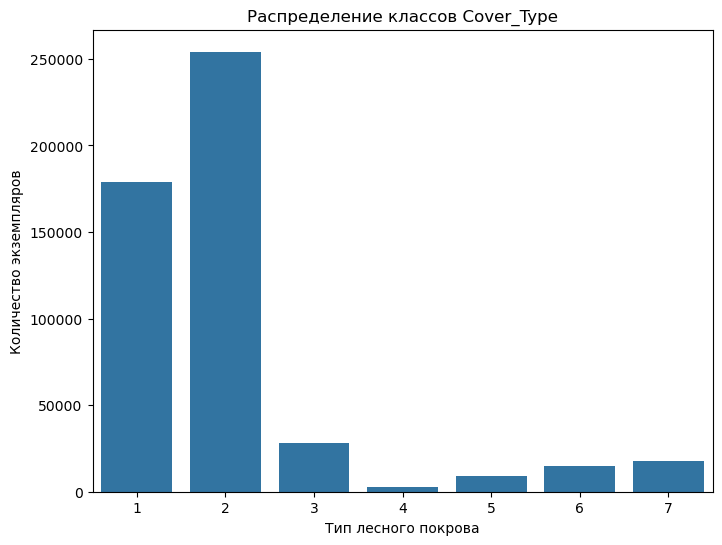

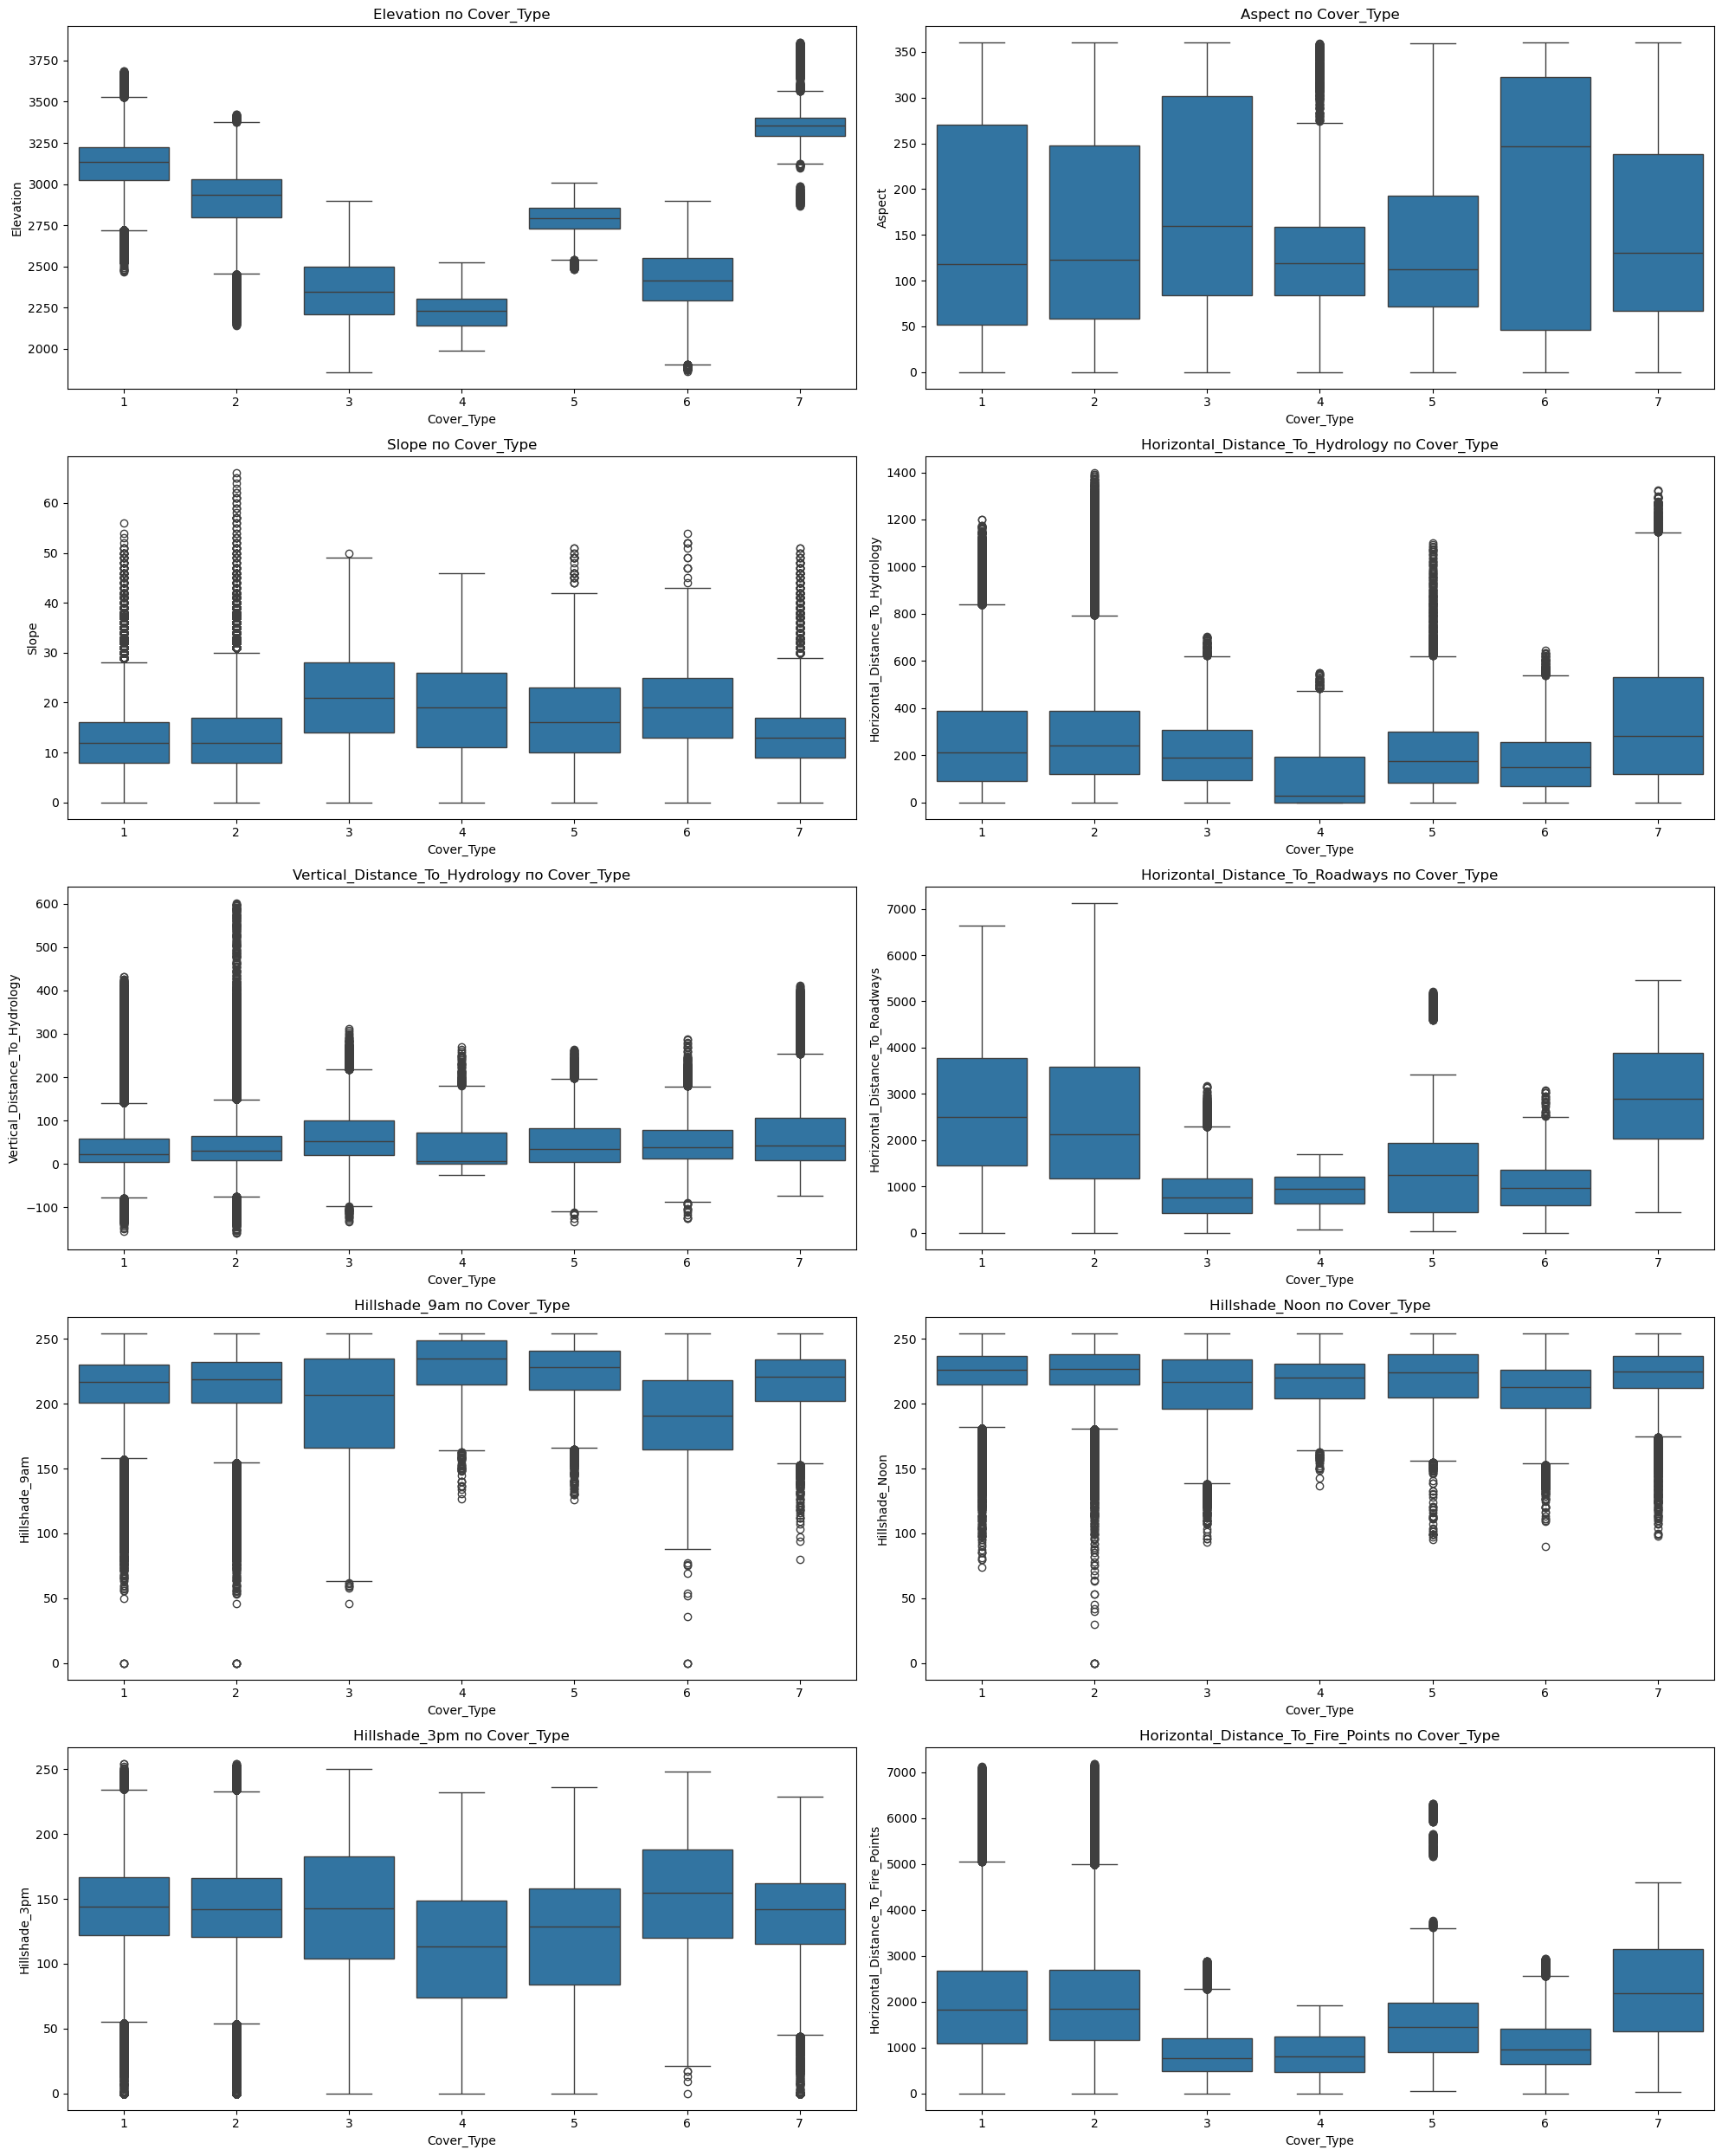

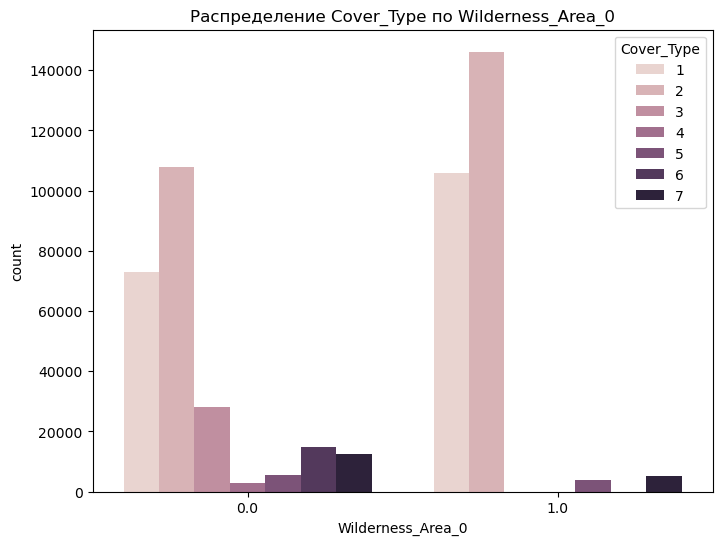

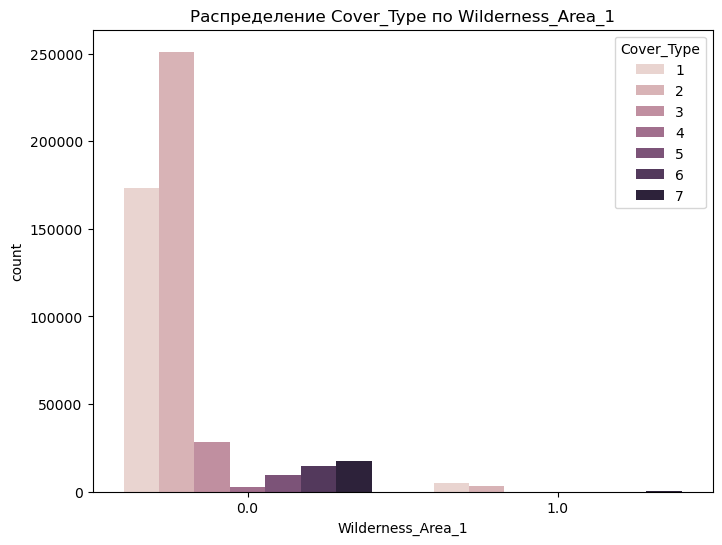

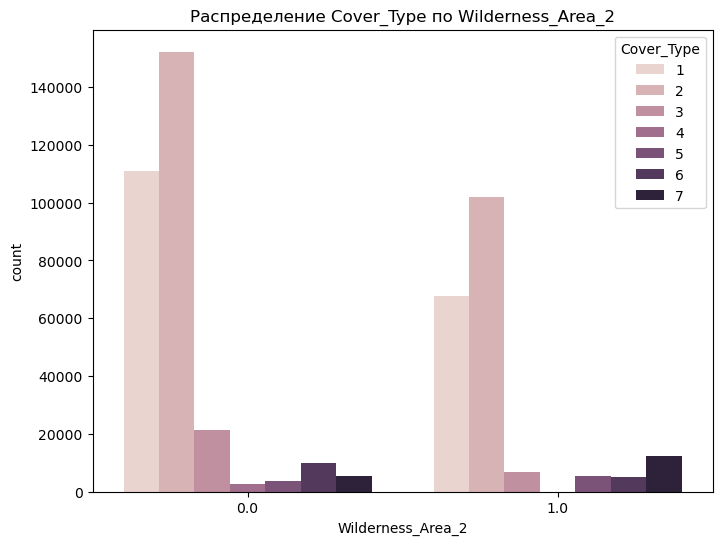

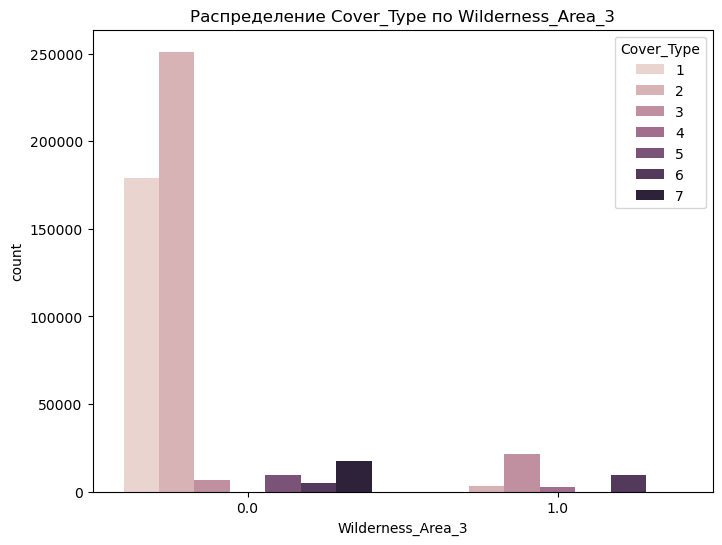

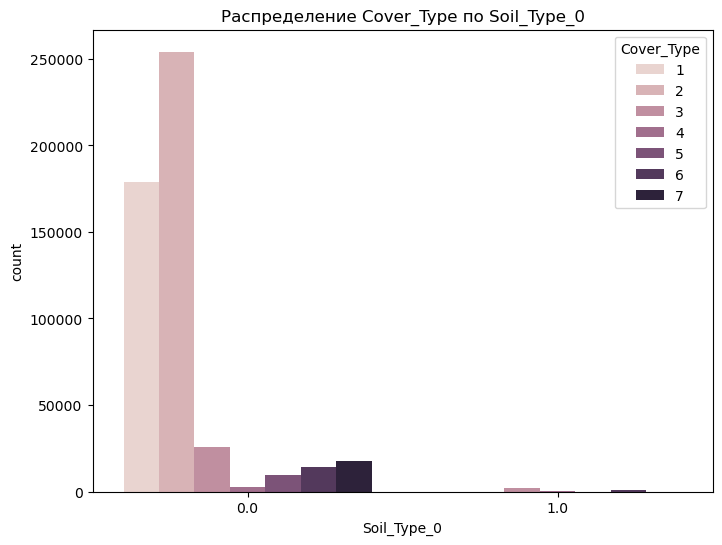

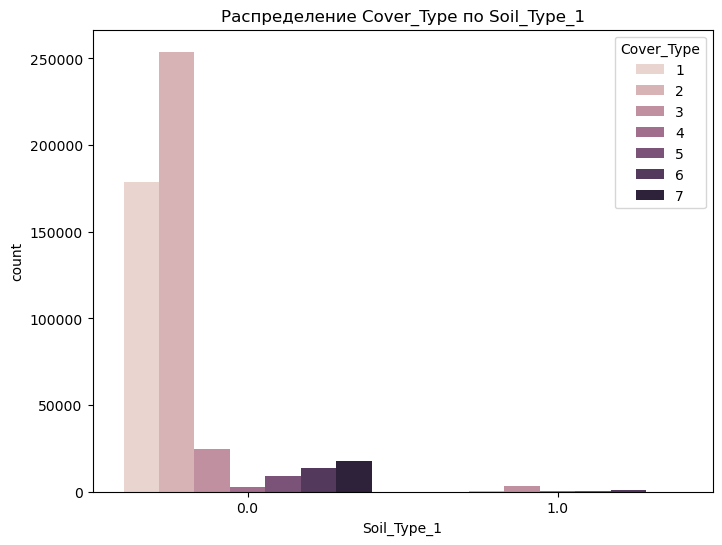

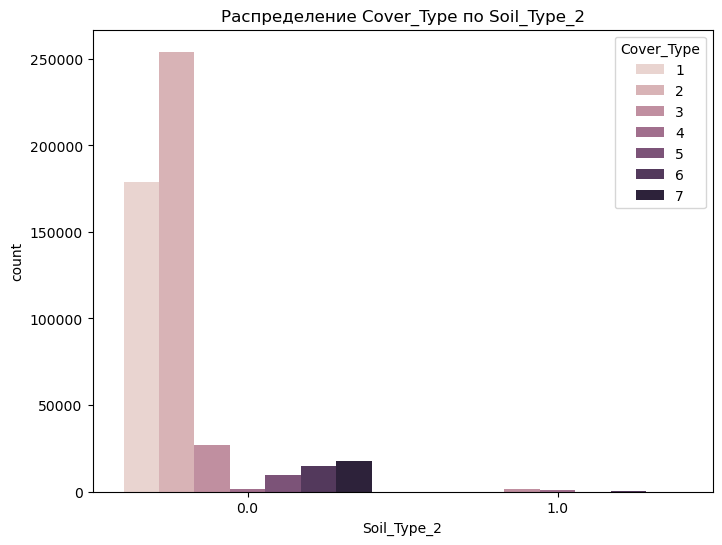

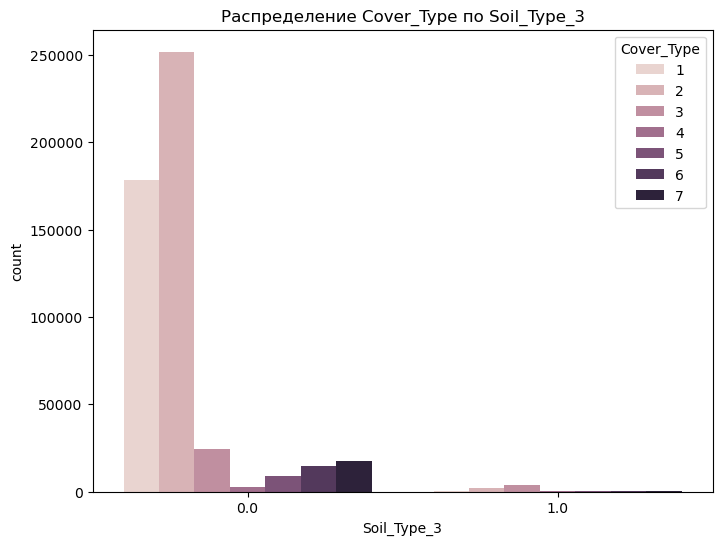

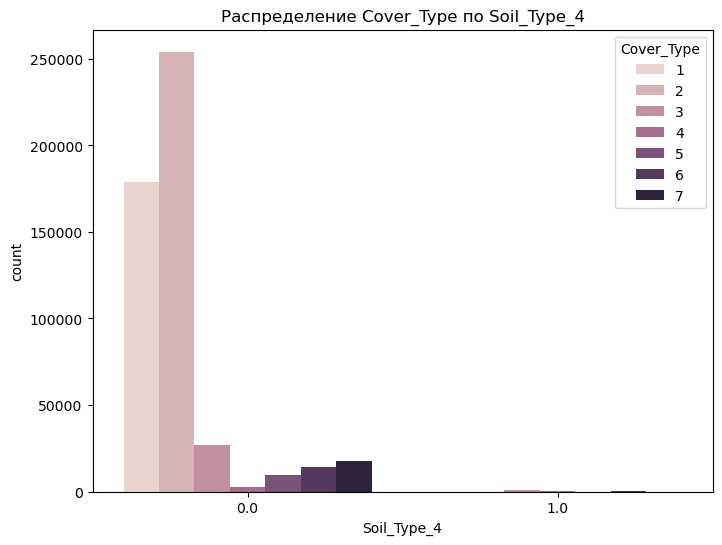

In [4]:
# Разделение признаков
numerical_features = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col not in ['Cover_Type']]
categorical_features = [col for col in df.columns if 'Wilderness_Area' in col or 'Soil_Type' in col]

print(f"\nКоличество числовых признаков: {len(numerical_features)}")
print(f"Количество категориальных (бинарных) признаков: {len(categorical_features)}")

# Одномерная визуализация (гистограммы для числовых признаков)
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    if i >= 15: # Ограничим количество графиков для наглядности
        break
    plt.subplot(4, 4, i + 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

# Распределение классов целевого признака (уже смотрели value_counts, но можно и графически)
plt.figure(figsize=(8, 6))
sns.countplot(x='Cover_Type', data=df)
plt.title('Распределение классов Cover_Type')
plt.xlabel('Тип лесного покрова')
plt.ylabel('Количество экземпляров')
plt.show()

# Многомерная визуализация (Box plots для числовых признаков относительно Cover_Type)
# Выберем несколько ключевых числовых признаков для box plots, так как их много.
key_numerical_features = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
                         'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                         'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                         'Horizontal_Distance_To_Fire_Points']

plt.figure(figsize=(20, 25))
for i, feature in enumerate(key_numerical_features):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(x='Cover_Type', y=feature, data=df)
    plt.title(f'{feature} по Cover_Type')
plt.tight_layout()
plt.show()

# Визуализация категориальных признаков (Wilderness_Area) относительно Cover_Type
# Для Soil_Type их 40, это будет слишком много для одного графика.
wilderness_cols = [col for col in categorical_features if 'Wilderness_Area' in col]
for col in wilderness_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, hue='Cover_Type', data=df)
    plt.title(f'Распределение Cover_Type по {col}')
    plt.show()

# Для Soil_Type, можно посмотреть на первые 5-10
soil_cols = [col for col in categorical_features if 'Soil_Type' in col][:5] # Берем первые 5 для примера
for col in soil_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, hue='Cover_Type', data=df)
    plt.title(f'Распределение Cover_Type по {col}')
    plt.show()

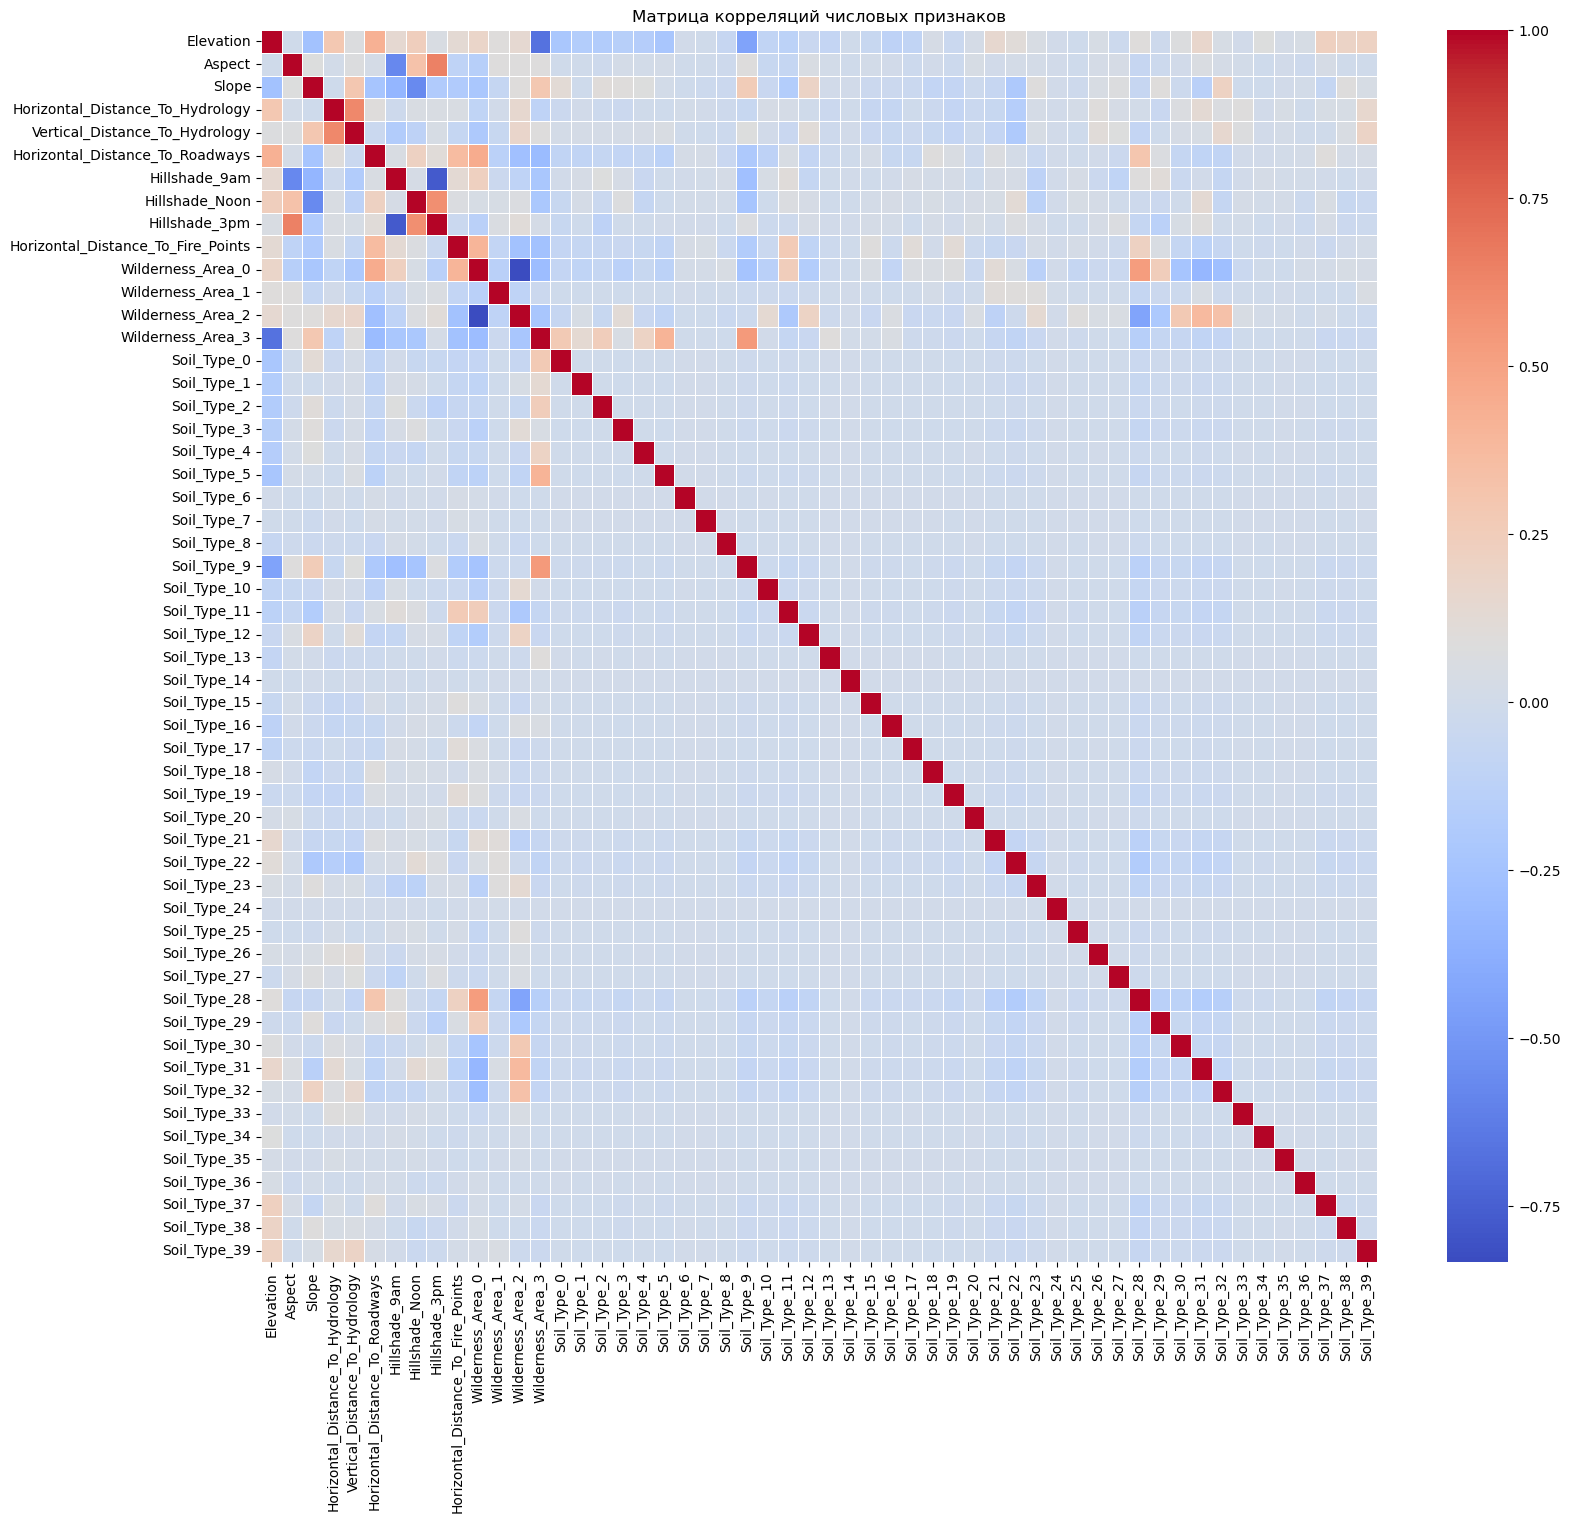


--- Пары сильно коррелированных числовых признаков (|корреляция| > 0.8) ---
'Wilderness_Area_2' и 'Wilderness_Area_0': -0.83

--- Корреляция числовых признаков с Cover_Type (Pearson) ---
Cover_Type                            1.000000
Wilderness_Area_3                     0.348599
Soil_Type_9                           0.252168
Soil_Type_37                          0.170576
Slope                                 0.163752
Soil_Type_38                          0.163077
Soil_Type_1                           0.121361
Soil_Type_5                           0.121226
Soil_Type_34                          0.109878
Vertical_Distance_To_Hydrology        0.102207
Soil_Type_0                           0.097510
Soil_Type_39                          0.091881
Soil_Type_16                          0.089422
Soil_Type_36                          0.086384
Soil_Type_3                           0.085740
Soil_Type_4                           0.083659
Soil_Type_2                           0.073132
Wilderness_Ar

In [5]:
# Вычисление матрицы корреляций только для числовых признаков
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Матрица корреляций числовых признаков')
plt.show()

# Вывод пар сильно коррелированных признаков (например, |corr| > 0.8)
highly_correlated_features = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            highly_correlated_features.append((colname1, colname2, correlation_matrix.iloc[i, j]))

print("\n--- Пары сильно коррелированных числовых признаков (|корреляция| > 0.8) ---")
if highly_correlated_features:
    for feature1, feature2, corr_value in highly_correlated_features:
        print(f"'{feature1}' и '{feature2}': {corr_value:.2f}")
else:
    print("Сильно коррелированных числовых признаков не обнаружено.")

# Для целевого признака: корреляция числовых признаков с Cover_Type
# Важно помнить, что Pearson correlation подходит для линейных зависимостей.
# Для многоклассовой классификации это может быть не самым показательным методом.
# Тем не менее, посмотрим на это:
df_corr_target = df[numerical_features + ['Cover_Type']].corr()['Cover_Type'].sort_values(ascending=False)
print("\n--- Корреляция числовых признаков с Cover_Type (Pearson) ---")
print(df_corr_target)

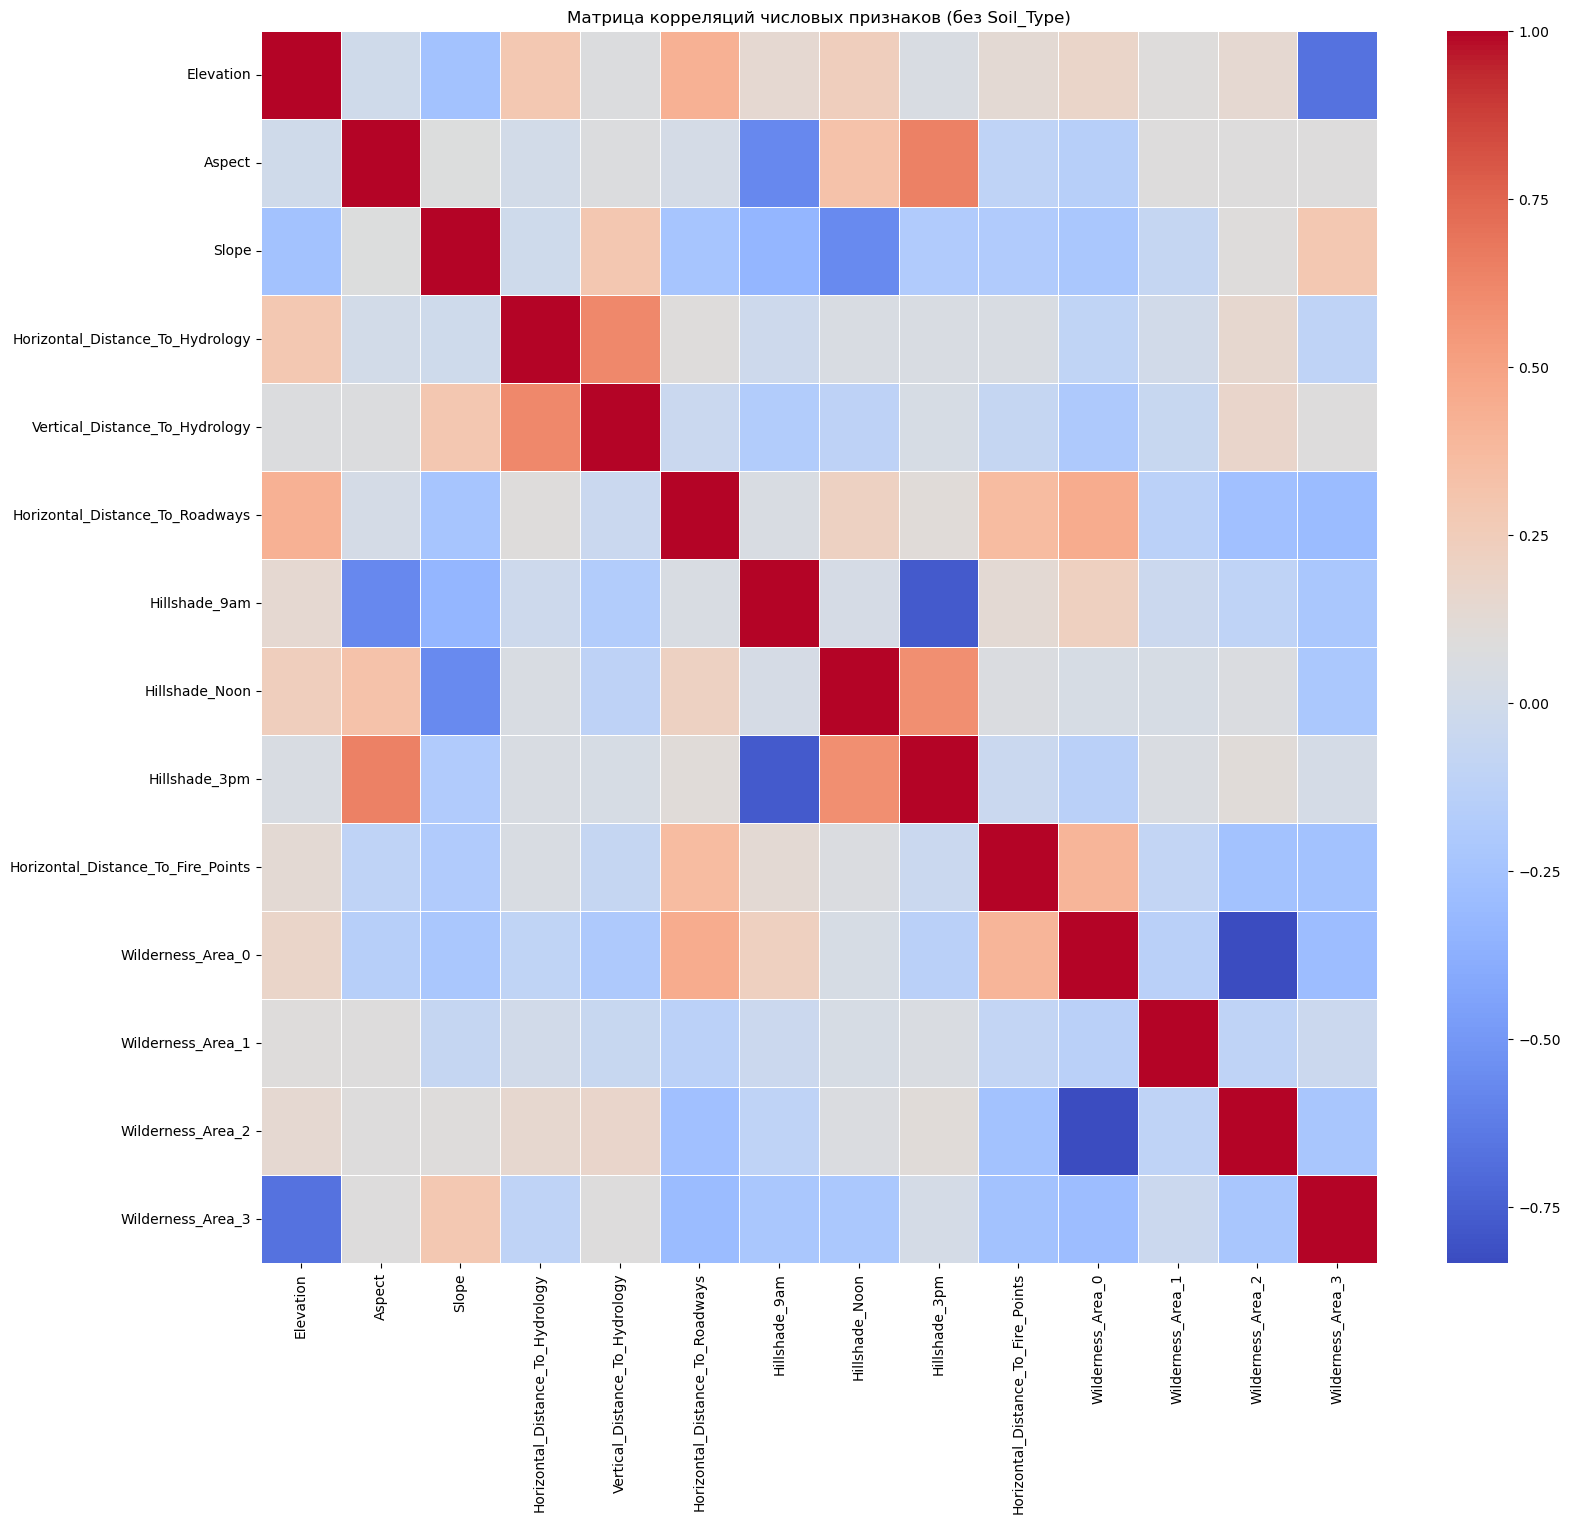


--- Пары сильно коррелированных числовых признаков (|корреляция| > 0.8) (без Soil_Type) ---
'Wilderness_Area_2' и 'Wilderness_Area_0': -0.83

--- Корреляция числовых признаков с Cover_Type (Pearson) (без Soil_Type) ---
Cover_Type                            1.000000
Wilderness_Area_3                     0.348599
Slope                                 0.163752
Vertical_Distance_To_Hydrology        0.102207
Wilderness_Area_2                     0.072574
Aspect                                0.034976
Horizontal_Distance_To_Hydrology     -0.004113
Hillshade_3pm                        -0.038649
Wilderness_Area_1                    -0.048874
Hillshade_9am                        -0.054679
Horizontal_Distance_To_Fire_Points   -0.093987
Hillshade_Noon                       -0.105208
Horizontal_Distance_To_Roadways      -0.153851
Wilderness_Area_0                    -0.240075
Elevation                            -0.270652
Name: Cover_Type, dtype: float64


In [6]:
# Убрать SOIL_type из списка числовых признаков для корреляционной матрицы
numerical_features_for_corr = [col for col in numerical_features if 'Soil_Type' not in col]

# Вычисление матрицы корреляций только для числовых признаков без Soil_Type
correlation_matrix = df[numerical_features_for_corr].corr()

plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Матрица корреляций числовых признаков (без Soil_Type)')
plt.show()

# Вывод пар сильно коррелированных признаков (например, |corr| > 0.8)
highly_correlated_features = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            highly_correlated_features.append((colname1, colname2, correlation_matrix.iloc[i, j]))

print("\n--- Пары сильно коррелированных числовых признаков (|корреляция| > 0.8) (без Soil_Type) ---")
if highly_correlated_features:
    for feature1, feature2, corr_value in highly_correlated_features:
        print(f"'{feature1}' и '{feature2}': {corr_value:.2f}")
else:
    print("Сильно коррелированных числовых признаков не обнаружено.")

# Для целевого признака: корреляция числовых признаков с Cover_Type (без Soil_Type)
df_corr_target = df[numerical_features_for_corr + ['Cover_Type']].corr()['Cover_Type'].sort_values(ascending=False)
print("\n--- Корреляция числовых признаков с Cover_Type (Pearson) (без Soil_Type) ---")
print(df_corr_target)

In [7]:
df_enhanced = df.copy()

df_enhanced['Distance_to_Water'] = np.sqrt(df_enhanced['Horizontal_Distance_To_Hydrology']**2 +
                                            df_enhanced['Vertical_Distance_To_Hydrology']**2)
df_enhanced['Avg_Hillshade'] = (df_enhanced['Hillshade_9am'] + df_enhanced['Hillshade_Noon'] +
                                 df_enhanced['Hillshade_3pm']) / 3
df_enhanced['Hydro_Road_Fire_Distance'] = (df_enhanced['Horizontal_Distance_To_Hydrology'] +
                                            df_enhanced['Horizontal_Distance_To_Roadways'] +
                                            df_enhanced['Horizontal_Distance_To_Fire_Points'])
df_enhanced['Elevation_x_Slope'] = df_enhanced['Elevation'] * df_enhanced['Slope']

print("\n--- DataFrame с новыми атрибутами ---")
print(df_enhanced.head())

# Добавляем новые признаки в список числовых признаков для последующего анализа
numerical_features_enhanced = numerical_features + ['Distance_to_Water', 'Avg_Hillshade',
                                                    'Hydro_Road_Fire_Distance', 'Elevation_x_Slope']


--- DataFrame с новыми атрибутами ---
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0     2596.0    51.0    3.0                             258.0   
1     2590.0    56.0    2.0                             212.0   
2     2804.0   139.0    9.0                             268.0   
3     2785.0   155.0   18.0                             242.0   
4     2595.0    45.0    2.0                             153.0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                             0.0                            510.0   
1                            -6.0                            390.0   
2                            65.0                           3180.0   
3                           118.0                           3090.0   
4                            -1.0                            391.0   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0          221.0           232.0          148.0   
1          220.0           235.0          151.0

Distance_to_Water: Комбинированная дистанция до гидрологических объектов (гипотенуза от горизонтальной и вертикальной дистанции).  
Horizontal_Distance_To_Hydrology
2
 +Vertical_Distance_To_Hydrology
2


​

Avg_Hillshade: Среднее значение затенения. (Hillshade_9am+Hillshade_Noon+Hillshade_3pm)/3
Hydro_Road_Fire_Distance: Сумма расстояний до воды, дорог и огня (как общая удаленность). Horizontal_Distance_To_Hydrology+Horizontal_Distance_To_Roadways+Horizontal_Distance_To_Fire_Points
Elevation_x_Slope: Произведение высоты на наклон (может отражать уникальные экосистемы на определенных высотах и уклонах).

In [8]:
# Исходный набор признаков (без целевого)
X_original = df_enhanced.drop('Cover_Type', axis=1)
y_original = df_enhanced['Cover_Type'] # Целевой признак для SelectKBest

# 1. VarianceThreshold
# Определим порог. Признаки с дисперсией ниже этого порога будут удалены.
# Начнем с очень низкого порога, чтобы отфильтровать только совсем уж бесполезные признаки.
# Для бинарных признаков (Wilderness_Area, Soil_Type), низкая дисперсия может означать,
# что подавляющее большинство значений равно 0 или 1, что может быть информативным.
# Поэтому применим VarianceThreshold только к числовым признакам, а затем к бинарным.
# Или, лучше, применим его ко всему X, но с порогом, который учитывает размах значений.

# Для начала, исключим бинарные признаки из рассмотрения VarianceThreshold, если они сильно различаются.
# Но, учитывая, что они уже One-Hot encoded, и они могут быть разряженными,
# VarianceThreshold может быть полезен для их фильтрации, если класс представлен слишком редко.
# Однако, лучше использовать VarianceThreshold после One-Hot Encoding, если бы он не был сделан.
# В данном случае, бинарные признаки уже в X_original.

# Порог, например, 0.01.
selector = VarianceThreshold(threshold=0.01) # Можно настроить порог
selector.fit(X_original)
# Получаем названия признаков, которые прошли отбор
features_after_variance_threshold = X_original.columns[selector.get_support()]

print(f"\nКоличество признаков после VarianceThreshold (порог 0.01): {len(features_after_variance_threshold)}")
print(f"Удаленные признаки VarianceThreshold: {list(set(X_original.columns) - set(features_after_variance_threshold))}")

# Создадим DataFrame с признаками после VarianceThreshold
X_vt = X_original[features_after_variance_threshold]

# 2. SelectKBest с f_classif
# Выберем, например, 30 лучших признаков. Это число можно подбирать.
# Поскольку у нас 54 признака, 30 - это значительное сокращение.
k_best_selector = SelectKBest(score_func=f_classif, k=30) # Можно попробовать и другие значения K
k_best_selector.fit(X_vt, y_original) # Используем данные после VarianceThreshold
features_selected_kbest = X_vt.columns[k_best_selector.get_support()]

print(f"\nКоличество признаков после SelectKBest (k=30): {len(features_selected_kbest)}")
print(f"Отобранные признаки SelectKBest: {list(features_selected_kbest)}")

# Сформируем окончательный набор данных из существенных признаков
df_selected_features = df_enhanced[features_selected_kbest.tolist() + ['Cover_Type']]

print("\n--- DataFrame с отобранными существенными признаками ---")
print(df_selected_features.head())
print(f"Размер сформированного набора данных: {df_selected_features.shape}")


Количество признаков после VarianceThreshold (порог 0.01): 36
Удаленные признаки VarianceThreshold: ['Soil_Type_15', 'Soil_Type_0', 'Soil_Type_36', 'Soil_Type_27', 'Soil_Type_18', 'Soil_Type_24', 'Soil_Type_33', 'Soil_Type_6', 'Soil_Type_25', 'Soil_Type_2', 'Soil_Type_26', 'Soil_Type_8', 'Soil_Type_14', 'Soil_Type_13', 'Soil_Type_34', 'Soil_Type_1', 'Soil_Type_16', 'Soil_Type_35', 'Soil_Type_4', 'Soil_Type_7', 'Soil_Type_17', 'Soil_Type_20']

Количество признаков после SelectKBest (k=30): 30
Отобранные признаки SelectKBest: ['Elevation', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_3', 'Soil_Type_5', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_31', 'Soil_Type_37',

In [9]:
# 1. Масштабирование исходного набора данных (df_enhanced)

# Определяем числовые и бинарные/OHE признаки
# Исходные числовые признаки (включая добавленные)
numerical_cols_for_scaling_original = [col for col in df_enhanced.columns if col in numerical_features_enhanced]
# Бинарные/OHE признаки, которые не нужно масштабировать
binary_ohe_cols_original = [col for col in df_enhanced.columns if col.startswith('Wilderness_Area') or col.startswith('Soil_Type')]

# Создаем препроцессор для масштабирования числовых признаков
preprocessor_original = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_cols_for_scaling_original)],
    remainder='passthrough' # Оставляем остальные признаки как есть (бинарные)
)

# Применяем масштабирование к исходному набору данных (без целевой переменной)
X_original_scaled = preprocessor_original.fit_transform(df_enhanced.drop('Cover_Type', axis=1))

# Получаем названия колонок после преобразования (это сложнее, так как ColumnTransformer меняет порядок)
# Признаки из numerical_cols_for_scaling_original будут первыми, затем остальные.
# Остальные признаки будут в том же порядке, что и в df_enhanced.drop('Cover_Type', axis=1),
# но исключая numerical_cols_for_scaling_original.

# Получаем названия колонок после transform для preprocessor_original
# Сначала идут масштабированные числовые колонки
scaled_feature_names_original = numerical_cols_for_scaling_original
# Затем идут колонки, которые не были преобразованы (remainder='passthrough')
passthrough_feature_names_original = [col for col in df_enhanced.drop('Cover_Type', axis=1).columns if col not in numerical_cols_for_scaling_original]

all_scaled_feature_names_original = scaled_feature_names_original + passthrough_feature_names_original

# Создаем DataFrame с масштабированными данными
df_original_scaled = pd.DataFrame(X_original_scaled, columns=all_scaled_feature_names_original)
df_original_scaled['Cover_Type'] = df_enhanced['Cover_Type'].values # Добавляем целевой признак
print("\n--- Исходный набор данных после Min-Max масштабирования ---")
print(df_original_scaled.head())


# 2. Масштабирование сформированного набора данных (df_selected_features)

# Определяем числовые и бинарные/OHE признаки в df_selected_features
numerical_cols_for_scaling_selected = [col for col in df_selected_features.columns if col in numerical_features_enhanced] # Используем расширенный список численных признаков
binary_ohe_cols_selected = [col for col in df_selected_features.columns if (col.startswith('Wilderness_Area') or col.startswith('Soil_Type')) and col in df_selected_features.columns]


preprocessor_selected = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_cols_for_scaling_selected)],
    remainder='passthrough'
)

# Применяем масштабирование к сформированному набору данных (без целевой переменной)
X_selected_scaled = preprocessor_selected.fit_transform(df_selected_features.drop('Cover_Type', axis=1))

# Получаем названия колонок после transform для preprocessor_selected
scaled_feature_names_selected = numerical_cols_for_scaling_selected
passthrough_feature_names_selected = [col for col in df_selected_features.drop('Cover_Type', axis=1).columns if col not in numerical_cols_for_scaling_selected]

all_scaled_feature_names_selected = scaled_feature_names_selected + passthrough_feature_names_selected

# Создаем DataFrame с масштабированными данными
df_selected_features_scaled = pd.DataFrame(X_selected_scaled, columns=all_scaled_feature_names_selected)
df_selected_features_scaled['Cover_Type'] = df_selected_features['Cover_Type'].values # Добавляем целевой признак
print("\n--- Сформированный набор данных после Min-Max масштабирования ---")
print(df_selected_features_scaled.head())

# Сохраняем исходные данные без изменений для анализа (они уже в df_enhanced)
# df_original = df_enhanced.copy() - не нужно, df_enhanced уже есть


--- Исходный набор данных после Min-Max масштабирования ---
   Elevation    Aspect     Slope  Horizontal_Distance_To_Hydrology  \
0   0.368684  0.141667  0.045455                          0.184681   
1   0.365683  0.155556  0.030303                          0.151754   
2   0.472736  0.386111  0.136364                          0.191840   
3   0.463232  0.430556  0.272727                          0.173228   
4   0.368184  0.125000  0.030303                          0.109520   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                        0.209211                         0.071659   
1                        0.201316                         0.054798   
2                        0.294737                         0.446817   
3                        0.364474                         0.434172   
4                        0.207895                         0.054939   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0       0.870079        0.913386       0.58267

df_enhanced (исходный + сгенерированные признаки)

df_original_scaled (исходный + сгенерированные признаки, масштабированный)

df_selected_features (сформированный набор данных из отобранных признаков)

df_selected_features_scaled (сформированный набор данных из отобранных признаков, масштабированный)

In [10]:

from scikeras.wrappers import KerasClassifier

def prepare_data_splits(df, target_column='Cover_Type', random_state=42):
    """
    Разделяет DataFrame на признаки (X) и целевую переменную (y),
    преобразует y в one-hot encoding и разделяет на обучающую, валидационную и тестовую выборки.
    """
    X = df.drop(target_column, axis=1)
    y_raw = df[target_column]

    # Преобразование целевой переменной в one-hot encoding
    # Классы Cover_Type начинаются с 1, поэтому нужно убедиться, что они смещены к 0-индексированию
    # или что to_categorical правильно обрабатывает максимальное значение.
    # Максимальное значение класса + 1 будет общим количеством классов.
    num_classes = y_raw.nunique() # ИСПРАВЛЕНИЕ: Количество уникальных классов

    y = to_categorical(y_raw - 1, num_classes=num_classes) # Эта строка остается

    # Разделение на train и temp (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y_raw)

    # Разделение temp на validation и test
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state, stratify=y_temp)

    print(f"Размер обучающей выборки X: {X_train.shape}, y: {y_train.shape}")
    print(f"Размер валидационной выборки X: {X_val.shape}, y: {y_val.shape}")
    print(f"Размер тестовой выборки X: {X_test.shape}, y: {y_test.shape}")
    print("-" * 30)

    return X_train, X_val, X_test, y_train, y_val, y_test, num_classes

# Словарь для хранения всех наборов данных
datasets = {
    "Original_Enhanced": df_enhanced,
    "Original_Enhanced_Scaled": df_original_scaled,
    "Selected_Features": df_selected_features,
    "Selected_Features_Scaled": df_selected_features_scaled
}

# Словарь для хранения всех сплитов данных
data_splits = {}
num_classes_dict = {}

for name, dataset in datasets.items():
    print(f"Подготовка данных для набора: {name}")
    X_train, X_val, X_test, y_train, y_val, y_test, num_classes = prepare_data_splits(dataset)
    data_splits[name] = {
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test
    }
    num_classes_dict[name] = num_classes

# Проверка, что количество классов одинаково для всех наборов (должно быть 7)
assert all(value == 7 for value in num_classes_dict.values()), "Количество классов не соответствует 7!"
print(f"Общее количество классов: {num_classes_dict['Original_Enhanced']}")

Подготовка данных для набора: Original_Enhanced
Размер обучающей выборки X: (353747, 58), y: (353747, 7)
Размер валидационной выборки X: (75803, 58), y: (75803, 7)
Размер тестовой выборки X: (75804, 58), y: (75804, 7)
------------------------------
Подготовка данных для набора: Original_Enhanced_Scaled
Размер обучающей выборки X: (353747, 58), y: (353747, 7)
Размер валидационной выборки X: (75803, 58), y: (75803, 7)
Размер тестовой выборки X: (75804, 58), y: (75804, 7)
------------------------------
Подготовка данных для набора: Selected_Features
Размер обучающей выборки X: (353747, 30), y: (353747, 7)
Размер валидационной выборки X: (75803, 30), y: (75803, 7)
Размер тестовой выборки X: (75804, 30), y: (75804, 7)
------------------------------
Подготовка данных для набора: Selected_Features_Scaled
Размер обучающей выборки X: (353747, 30), y: (353747, 7)
Размер валидационной выборки X: (75803, 30), y: (75803, 7)
Размер тестовой выборки X: (75804, 30), y: (75804, 7)
---------------------

In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Input, BatchNormalization, MaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

In [ ]:
def 
# Построение модели
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_cat.shape[1], activation='softmax'))

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train_reshaped, y_train, 
                    epochs=20, 
                    batch_size=128, 
                    validation_split=0.2,
                    verbose=1)

# Оценка модели на тестовой выборке
test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

# ASSHOLE

У меня вопросы к отпору параметров - по какому принципу мы нахуй выкинули вс

In [13]:
def create_1d_cnn_model(input_shape, num_classes, num_conv_layers=2, filters=128,
                         kernel_size=3, pool_size=2, use_batch_norm=True,
                         num_dense_layers=1, dense_units=128,
                         optimizer='adam', learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape)) # input_shape уже должен быть (num_features, 1)

    for i in range(num_conv_layers):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'))
        if use_batch_norm:
            model.add(BatchNormalization())
        # Добавляем MaxPooling1D, если есть смысл и достаточное количество признаков
        if input_shape[0] > pool_size * (i + 1) : # Убедимся, что размерность не станет слишком маленькой
            model.add(MaxPooling1D(pool_size=pool_size))
        else:
            # Если MaxPooling1D может сделать размерность 0, пропускаем его
            # или можно настроить логику по-другому, например, убрать padding='same'
            # и добавить его только на первом слое
            pass # Пропускаем MaxPooling, если он приведет к 0 размерности

    model.add(Flatten())

    for _ in range(num_dense_layers):
        model.add(Dense(dense_units, activation='relu'))
        if use_batch_norm: # Можно добавить BatchNormalization и здесь, но это опционально
            model.add(BatchNormalization())

    model.add(Dense(num_classes, activation='softmax'))

    # Выбор оптимизатора
    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate) # Default

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# --- Функция для создания полносвязной нейросетевой модели (MLP) (без изменений) ---
def create_mlp_model(input_shape, num_classes, optimizer='adam', learning_rate=0.001,
                     hidden_layers=1, dense_units=128):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    for _ in range(hidden_layers):
        model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# --- Функция для оценки моделей (без изменений) ---
def evaluate_model_on_split(model, X_input, y_true_one_hot, num_classes, model_name="Model", split_name="Unknown"):
    print(f"\n--- Оценка {model_name} на {split_name} наборе ---")

    if isinstance(X_input, pd.DataFrame):
        X_input = X_input.values

    # Проверяем, если модель 1D CNN, то вход должен быть 3D
    if len(model.input_shape) == 3 and len(X_input.shape) == 2:
        X_input = X_input.reshape(X_input.shape[0], X_input.shape[1], 1)

    y_pred_proba = model.predict(X_input, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_true_one_hot, axis=1)

    metrics = {}
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    metrics[f'{split_name}_Accuracy'] = acc
    metrics[f'{split_name}_Balanced_Accuracy'] = bal_acc
    metrics[f'{split_name}_F1_Macro'] = f1_macro
    metrics[f'{split_name}_F1_Weighted'] = f1_weighted

    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"F1-score (Macro): {f1_macro:.4f}")
    print(f"F1-score (Weighted): {f1_weighted:.4f}")

    print("\n--- Отчет по классификации (по классам) ---")
    print(classification_report(y_true, y_pred, target_names=[f'Class {i+1}' for i in range(num_classes)], zero_division=0))

    return metrics

# --- 7. Прямое тестирование конкретных гиперпараметров и сравнение моделей ---

# Словарь для хранения результатов всех моделей
results = []

# Определение общих параметров для нейросетей
common_nn_params = {
    'epochs': 50,
    'batch_size': 32, # Или 64, как в вашем примере, но 32 чаще лучше для начала
    'verbose': 0
}

# Ранняя остановка для предотвращения переобучения
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)


# Определяем комбинации гиперпараметров для MLP (без изменений)
mlp_hyperparameter_combinations = [
    {'optimizer': 'adam', 'learning_rate': 0.001, 'hidden_layers': 1, 'dense_units': 128},
    {'optimizer': 'rmsprop', 'learning_rate': 0.001, 'hidden_layers': 2, 'dense_units': 64},
    {'optimizer': 'sgd', 'learning_rate': 0.01, 'hidden_layers': 1, 'dense_units': 128},
    {'optimizer': 'adam', 'learning_rate': 0.0001, 'hidden_layers': 2, 'dense_units': 256},
]

print(f"Будет протестировано несколько комбинаций для 1D CNN и {len(mlp_hyperparameter_combinations)} для MLP.")

# Итерация по каждому набору данных
for name, splits in data_splits.items():
    X_train = splits['X_train']
    X_val = splits['X_val']
    y_train = splits['y_train']
    y_val = splits['y_val']
    y_train_raw = splits['y_train'] # Используем y_train_raw из data_splits
    y_val_raw = splits['y_val']   # Используем y_val_raw из data_splits

    num_classes = num_classes_dict[name]
    input_shape = X_train.shape[1] # Это число признаков

    print(f"\n======== Анализ для набора данных: {name} ========")

    # --- Вычисление весов классов для обучающей выборки ---
    class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y_train_raw - 1), # Приводим к 0-based для классов
        y=y_train_raw - 1 # Передаем 0-based метки
    )
    class_weights_dict = dict(enumerate(class_weights))
    print(f"Веса классов для {name}: {class_weights_dict}")

    # --- НОВЫЙ ЦИКЛ ОБУЧЕНИЯ И ОЦЕНКИ 1D CNN МОДЕЛИ (адаптирован) ---
    print("\n--- Тестирование 1D CNN моделей (новая архитектура) ---")

    # Подготовка данных для CNN (здесь X_train_cnn уже 3D)
    X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val_cnn = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test_cnn = splits['X_test'].values.reshape(splits['X_test'].shape[0], splits['X_test'].shape[1], 1)
    y_test = splits['y_test'] # One-hot encoded

    cnn_input_shape = (input_shape, 1) # (num_features, 1)

    train_dataset_cnn = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train))
    train_dataset_cnn = train_dataset_cnn.shuffle(buffer_size=1024).batch(common_nn_params['batch_size']).prefetch(tf.data.AUTOTUNE)

    val_dataset_cnn = tf.data.Dataset.from_tensor_slices((X_val_cnn, y_val))
    val_dataset_cnn = val_dataset_cnn.batch(common_nn_params['batch_size']).prefetch(tf.data.AUTOTUNE)

    # Динамический kernel_size
    current_kernel_size = min(3, input_shape) if input_shape > 0 else 1
    if input_shape < 3 and input_shape > 0: current_kernel_size = input_shape
    if current_kernel_size <= 0:
        print(f"Skipping 1D CNN for {name}: invalid kernel_size {current_kernel_size}. Input shape: {input_shape}")
        # Если нужно сохранить в results, то сделайте это здесь
        results.append({
            'Model_Type': '1D_CNN',
            'Dataset': name,
            'Model_Config': 'Skipped (Invalid Kernel Size)',
            'error': f'invalid kernel_size {current_kernel_size}'
        })
        # Пропускаем дальнейшую обработку 1D CNN для этого набора данных
        # и переходим к MLP
        pass
    else:
        # Параметры модели для этой новой 1D CNN
        # Используем оптимизатор и LR по умолчанию или заданные
        fixed_cnn_params_for_this_model = {
            'num_conv_layers': 2, 'filters': 128, 'kernel_size': current_kernel_size,
            'pool_size': 2,
            'use_batch_norm': True,
            'num_dense_layers': 1, 'dense_units': 128,
            'optimizer': 'adam', # Можно сделать это параметром, если хотите
            'learning_rate': 0.001 # Можно сделать это параметром
        }

        print(f"\n--- 1D CNN (Fixed Config) для {name}: {fixed_cnn_params_for_this_model} ---")
        model_name_cnn = f"1D CNN (New Arch - Optim: {fixed_cnn_params_for_this_model['optimizer']}, LR: {fixed_cnn_params_for_this_model['learning_rate']}, ConvLayers: {fixed_cnn_params_for_this_model['num_conv_layers']}, Filters: {fixed_cnn_params_for_this_model['filters']}, Kernel: {fixed_cnn_params_for_this_model['kernel_size']}, Dense: {fixed_cnn_params_for_this_model['dense_units']}, BN: {fixed_cnn_params_for_this_model['use_batch_norm']})"

        cnn_model = create_1d_cnn_model(input_shape=cnn_input_shape, num_classes=num_classes, **fixed_cnn_params_for_this_model)

        cnn_model.fit(
            train_dataset_cnn,
            epochs=common_nn_params['epochs'],
            batch_size=common_nn_params['batch_size'],
            validation_data=val_dataset_cnn,
            class_weight=class_weights_dict,
            callbacks=[early_stopping],
            verbose=common_nn_params['verbose']
        )

        # Оценка на обучающей выборке
        train_metrics = evaluate_model_on_split(cnn_model, X_train_cnn, y_train, num_classes, model_name_cnn, "Train")
        # Оценка на валидационной выборке
        val_metrics = evaluate_model_on_split(cnn_model, X_val_cnn, y_val, num_classes, model_name_cnn, "Validation")
        # Оценка на тестовой выборке
        test_metrics = evaluate_model_on_split(cnn_model, X_test_cnn, y_test, num_classes, model_name_cnn, "Test")

        # Сохранение результатов
        all_metrics = {**train_metrics, **val_metrics, **test_metrics}
        results.append({
            'Model_Type': '1D_CNN (New Arch)',
            'Dataset': name,
            'Model_Config': model_name_cnn,
            **fixed_cnn_params_for_this_model, # Добавляем параметры в результаты
            'Optimizer': fixed_cnn_params_for_this_model['optimizer'], # Добавляем явно, если не все параметры в **fixed_cnn_params_for_this_model
            'Learning_Rate': fixed_cnn_params_for_this_model['learning_rate'],
            **all_metrics
        })


Будет протестировано несколько комбинаций для 1D CNN и 4 для MLP.

======== Анализ для набора данных: Original_Enhanced ========


TypeError: unhashable type: 'numpy.ndarray'

In [ ]:

from scikeras.wrappers import KerasClassifier # Оставляем, если нужен для других частей

def prepare_data_splits(df, target_column='Cover_Type', random_state=42):
    """
    Разделяет DataFrame на признаки (X) и целевую переменную (y),
    преобразует y в one-hot encoding и разделяет на обучающую, валидационную и тестовую выборки.
    Теперь также возвращает сырые (не one-hot) метки для каждой выборки.
    """
    X = df.drop(target_column, axis=1)
    y_raw = df[target_column] # ЭТО ВАЖНО: сохраняем сырые метки здесь

    num_classes = y_raw.nunique()

    y_one_hot = to_categorical(y_raw - 1, num_classes=num_classes) # Преобразуем в one-hot для модели

    # Разделение на train и temp (val + test)
    # y_raw используется для стратификации, чтобы сохранить распределение классов
    X_train, X_temp, y_train_one_hot, y_temp_one_hot, y_train_raw_split, y_temp_raw_split = \
        train_test_split(X, y_one_hot, y_raw, test_size=0.3, random_state=random_state, stratify=y_raw)

    # Разделение temp на validation и test
    # y_temp_raw_split используется для стратификации val/test
    X_val, X_test, y_val_one_hot, y_test_one_hot, y_val_raw_split, y_test_raw_split = \
        train_test_split(X_temp, y_temp_one_hot, y_temp_raw_split, test_size=0.5, random_state=random_state, stratify=y_temp_raw_split)

    print(f"Размер обучающей выборки X: {X_train.shape}, y: {y_train_one_hot.shape}")
    print(f"Размер валидационной выборки X: {X_val.shape}, y: {y_val_one_hot.shape}")
    print(f"Размер тестовой выборки X: {X_test.shape}, y: {y_test_one_hot.shape}")
    print("-" * 30)

    # ВОЗВРАЩАЕМ КАК one-hot (для моделей) И raw (для class_weight и balanced_accuracy)
    return X_train, X_val, X_test, y_train_one_hot, y_val_one_hot, y_test_one_hot, num_classes, y_train_raw_split, y_val_raw_split, y_test_raw_split

# Словарь для хранения всех наборов данных (без изменений, предполагается, что df_enhanced и т.д. определены выше)
datasets = {
    "Original_Enhanced": df_enhanced,
    "Original_Enhanced_Scaled": df_original_scaled,
    "Selected_Features": df_selected_features,
    "Selected_Features_Scaled": df_selected_features_scaled
}

# Словарь для хранения всех сплитов данных
data_splits = {}
num_classes_dict = {}

for name, dataset in datasets.items():
    print(f"Подготовка данных для набора: {name}")
    # Теперь prepare_data_splits возвращает 10 значений
    X_train, X_val, X_test, y_train_one_hot, y_val_one_hot, y_test_one_hot, num_classes, y_train_raw, y_val_raw, y_test_raw = prepare_data_splits(dataset)
    data_splits[name] = {
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'y_train': y_train_one_hot, 'y_val': y_val_one_hot, 'y_test': y_test_one_hot, # one-hot для обучения
        'y_train_raw': y_train_raw, 'y_val_raw': y_val_raw, 'y_test_raw': y_test_raw # raw для class_weight и отчетов
    }
    num_classes_dict[name] = num_classes

# Проверка, что количество классов одинаково для всех наборов (должно быть 7)
assert all(value == 7 for value in num_classes_dict.values()), "Количество классов не соответствует 7!"
print(f"Общее количество классов: {num_classes_dict['Original_Enhanced']}")

# --- Функция для создания одномерной сверточной нейросетевой модели (1D CNN) ---
# Без изменений, так как эта функция была корректна
def create_1d_cnn_model(input_shape, num_classes, num_conv_layers=2, filters=128,
                         kernel_size=3, pool_size=2, use_batch_norm=True,
                         num_dense_layers=1, dense_units=128,
                         optimizer='adam', learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))

    for i in range(num_conv_layers):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'))
        if use_batch_norm:
            model.add(BatchNormalization())
        if input_shape[0] > pool_size * (i + 1) :
            model.add(MaxPooling1D(pool_size=pool_size))
        else:
            pass

    model.add(Flatten())

    for _ in range(num_dense_layers):
        model.add(Dense(dense_units, activation='relu'))
        if use_batch_norm:
            model.add(BatchNormalization())

    model.add(Dense(num_classes, activation='softmax'))

    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# --- Функция для создания полносвязной нейросетевой модели (MLP) (без изменений) ---
# Без изменений, так как эта функция была корректна
def create_mlp_model(input_shape, num_classes, optimizer='adam', learning_rate=0.001,
                     hidden_layers=1, dense_units=128):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    for _ in range(hidden_layers):
        model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    if optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    elif optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# --- Функция для оценки моделей (без изменений) ---
# Эта функция должна принимать one-hot для y_true_one_hot, и извлекать y_true для сравнения
def evaluate_model_on_split(model, X_input, y_true_one_hot, num_classes, model_name="Model", split_name="Unknown"):
    print(f"\n--- Оценка {model_name} на {split_name} наборе ---")

    if isinstance(X_input, pd.DataFrame):
        X_input = X_input.values

    # Проверяем, если модель 1D CNN, то вход должен быть 3D
    if len(model.input_shape) == 3 and len(X_input.shape) == 2:
        X_input = X_input.reshape(X_input.shape[0], X_input.shape[1], 1)

    y_pred_proba = model.predict(X_input, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1) # Предсказанные классы (0-indexed)
    y_true = np.argmax(y_true_one_hot, axis=1) # Истинные классы (0-indexed)

    metrics = {}
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    metrics[f'{split_name}_Accuracy'] = acc
    metrics[f'{split_name}_Balanced_Accuracy'] = bal_acc
    metrics[f'{split_name}_F1_Macro'] = f1_macro
    metrics[f'{split_name}_F1_Weighted'] = f1_weighted

    print(f"Accuracy: {acc:.4f}")
    print(f"Balanced Accuracy: {bal_acc:.4f}")
    print(f"F1-score (Macro): {f1_macro:.4f}")
    print(f"F1-score (Weighted): {f1_weighted:.4f}")

    print("\n--- Отчет по классификации (по классам) ---")
    # target_names должны быть 1-indexed для "Class 1", "Class 2" и т.д.
    print(classification_report(y_true, y_pred, target_names=[f'Class {i+1}' for i in range(num_classes)], zero_division=0))

    return metrics

# --- 7. Прямое тестирование конкретных гиперпараметров и сравнение моделей ---

# Словарь для хранения результатов всех моделей
results = []

# Определение общих параметров для нейросетей
common_nn_params = {
    'epochs': 50,
    'batch_size': 32,
    'verbose': 0
}

# Ранняя остановка для предотвращения переобучения
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)


# Определяем комбинации гиперпараметров для MLP (без изменений)
mlp_hyperparameter_combinations = [
    {'optimizer': 'adam', 'learning_rate': 0.001, 'hidden_layers': 1, 'dense_units': 128},
    {'optimizer': 'rmsprop', 'learning_rate': 0.001, 'hidden_layers': 2, 'dense_units': 64},
    {'optimizer': 'sgd', 'learning_rate': 0.01, 'hidden_layers': 1, 'dense_units': 128},
    {'optimizer': 'adam', 'learning_rate': 0.0001, 'hidden_layers': 2, 'dense_units': 256},
]

print(f"Будет протестировано несколько комбинаций для 1D CNN и {len(mlp_hyperparameter_combinations)} для MLP.")

# Итерация по каждому набору данных
for name, splits in data_splits.items():
    X_train = splits['X_train']
    X_val = splits['X_val']
    y_train_one_hot = splits['y_train'] # one-hot для обучения
    y_val_one_hot = splits['y_val']   # one-hot для валидации
    y_train_raw = splits['y_train_raw'] # Сырые метки (Series) для class_weight
    y_val_raw = splits['y_val_raw']     # Сырые метки (Series) для class_weight

    num_classes = num_classes_dict[name]
    input_shape = X_train.shape[1] # Это число признаков

    print(f"\n======== Анализ для набора данных: {name} ========")

    # --- Вычисление весов классов для обучающей выборки ---
    # Важно: y_train_raw.values.ravel() для получения одномерного numpy массива
    y_train_raw_np = y_train_raw.values.ravel() # Это должно быть pd.Series.values.ravel()

    class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y_train_raw_np - 1), # Приводим к 0-based для классов (Cover_Type начинается с 1)
        y=y_train_raw_np - 1 # Передаем 0-based метки
    )
    class_weights_dict = dict(enumerate(class_weights))
    print(f"Веса классов для {name}: {class_weights_dict}")

    # --- НОВЫЙ ЦИКЛ ОБУЧЕНИЯ И ОЦЕНКИ 1D CNN МОДЕЛИ ---
    print("\n--- Тестирование 1D CNN моделей (новая архитектура) ---")

    X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val_cnn = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test_cnn = splits['X_test'].values.reshape(splits['X_test'].shape[0], splits['X_test'].shape[1], 1)
    y_test_one_hot = splits['y_test'] # One-hot encoded для оценки на тестовой выборке

    cnn_input_shape = (input_shape, 1)

    train_dataset_cnn = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train_one_hot))
    train_dataset_cnn = train_dataset_cnn.shuffle(buffer_size=1024).batch(common_nn_params['batch_size']).prefetch(tf.data.AUTOTUNE)

    val_dataset_cnn = tf.data.Dataset.from_tensor_slices((X_val_cnn, y_val_one_hot))
    val_dataset_cnn = val_dataset_cnn.batch(common_nn_params['batch_size']).prefetch(tf.data.AUTOTUNE)

    current_kernel_size = min(3, input_shape) if input_shape > 0 else 1
    if input_shape < 3 and input_shape > 0: current_kernel_size = input_shape
    if current_kernel_size <= 0:
        print(f"Skipping 1D CNN for {name}: invalid kernel_size {current_kernel_size}. Input shape: {input_shape}")
        results.append({
            'Model_Type': '1D_CNN (New Arch)',
            'Dataset': name,
            'Model_Config': 'Skipped (Invalid Kernel Size)',
            'error': f'invalid kernel_size {current_kernel_size}'
        })
        continue # Переходим к следующему набору данных
    else:
        fixed_cnn_params_for_this_model = {
            'num_conv_layers': 2, 'filters': 128, 'kernel_size': current_kernel_size,
            'pool_size': 2,
            'use_batch_norm': True,
            'num_dense_layers': 1, 'dense_units': 128,
            'optimizer': 'adam',
            'learning_rate': 0.001
        }

        print(f"\n--- 1D CNN (Fixed Config) для {name}: {fixed_cnn_params_for_this_model} ---")
        model_name_cnn = f"1D CNN (New Arch - Optim: {fixed_cnn_params_for_this_model['optimizer']}, LR: {fixed_cnn_params_for_this_model['learning_rate']}, ConvLayers: {fixed_cnn_params_for_this_model['num_conv_layers']}, Filters: {fixed_cnn_params_for_this_model['filters']}, Kernel: {fixed_cnn_params_for_this_model['kernel_size']}, Dense: {fixed_cnn_params_for_this_model['dense_units']}, BN: {fixed_cnn_params_for_this_model['use_batch_norm']})"

        cnn_model = create_1d_cnn_model(input_shape=cnn_input_shape, num_classes=num_classes, **fixed_cnn_params_for_this_model)

        cnn_model.fit(
            train_dataset_cnn,
            epochs=common_nn_params['epochs'],
            batch_size=common_nn_params['batch_size'],
            validation_data=val_dataset_cnn,
            class_weight=class_weights_dict,
            callbacks=[early_stopping],
            verbose=common_nn_params['verbose']
        )

        train_metrics = evaluate_model_on_split(cnn_model, X_train_cnn, y_train_one_hot, num_classes, model_name_cnn, "Train")
        val_metrics = evaluate_model_on_split(cnn_model, X_val_cnn, y_val_one_hot, num_classes, model_name_cnn, "Validation")
        test_metrics = evaluate_model_on_split(cnn_model, X_test_cnn, y_test_one_hot, num_classes, model_name_cnn, "Test")

        all_metrics = {**train_metrics, **val_metrics, **test_metrics}
        results.append({
            'Model_Type': '1D_CNN (New Arch)',
            'Dataset': name,
            'Model_Config': model_name_cnn,
            **fixed_cnn_params_for_this_model,
            'Optimizer': fixed_cnn_params_for_this_model['optimizer'],
            'Learning_Rate': fixed_cnn_params_for_this_model['learning_rate'],
            **all_metrics
        })

    # --- ТЕСТИРОВАНИЕ MLP ---
    print("\n--- Тестирование MLP моделей ---")

    X_train_mlp = X_train.values
    X_val_mlp = X_val.values
    X_test_mlp = splits['X_test'].values
    y_test_one_hot = splits['y_test'] # One-hot encoded для оценки на тестовой выборке

    train_dataset_mlp = tf.data.Dataset.from_tensor_slices((X_train_mlp, y_train_one_hot))
    train_dataset_mlp = train_dataset_mlp.shuffle(buffer_size=1024).batch(common_nn_params['batch_size']).prefetch(tf.data.AUTOTUNE)

    val_dataset_mlp = tf.data.Dataset.from_tensor_slices((X_val_mlp, y_val_one_hot))
    val_dataset_mlp = val_dataset_mlp.batch(common_nn_params['batch_size']).prefetch(tf.data.AUTOTUNE)


    for i, params in enumerate(mlp_hyperparameter_combinations):
        print(f"\n--- MLP Комбинация {i+1}/{len(mlp_hyperparameter_combinations)}: {params} ---")

        model_name_mlp = f"MLP (Optim: {params['optimizer']}, LR: {params['learning_rate']}, HiddenLayers: {params['hidden_layers']}, Dense: {params['dense_units']})"

        mlp_model = create_mlp_model(input_shape, num_classes,
                                     optimizer=params['optimizer'],
                                     learning_rate=params['learning_rate'],
                                     hidden_layers=params['hidden_layers'],
                                     dense_units=params['dense_units'])

        history = mlp_model.fit(train_dataset_mlp,
                                validation_data=val_dataset_mlp,
                                epochs=common_nn_params['epochs'],
                                callbacks=[early_stopping],
                                class_weight=class_weights_dict,
                                verbose=common_nn_params['verbose'])

        train_metrics = evaluate_model_on_split(mlp_model, X_train_mlp, y_train_one_hot, num_classes, model_name_mlp, "Train")
        val_metrics = evaluate_model_on_split(mlp_model, X_val_mlp, y_val_one_hot, num_classes, model_name_mlp, "Validation")
        test_metrics = evaluate_model_on_split(mlp_model, X_test_mlp, y_test_one_hot, num_classes, model_name_mlp, "Test")

        all_metrics = {**train_metrics, **val_metrics, **test_metrics}
        results.append({
            'Model_Type': 'MLP',
            'Dataset': name,
            'Model_Config': model_name_mlp,
            **params,
            **all_metrics
        })

# Сводная таблица результатов
results_df = pd.DataFrame(results)
print("\n\n--- Сводная таблица результатов всех моделей (1D CNN и MLP) со взвешиванием классов ---")
print(results_df.sort_values(by=['Dataset', 'Validation_Balanced_Accuracy'], ascending=[True, False]))
